### IMPORT LIBRARIES

In [1]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

### INITIALIZE POSE DETECTION MODEL

In [2]:
#INITIALIZE MEDIAPIPE POSE CLASS
mp_pose = mp.solutions.pose

#SETTING UP POSE FUNCTION
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence = 0.3, model_complexity=2)

#INITIALIZING MEDIAPIPE DRAWING CLASS, USEFUL FOR ANNOTATION
mp_drawing = mp.solutions.drawing_utils

### READ AN IMAGE

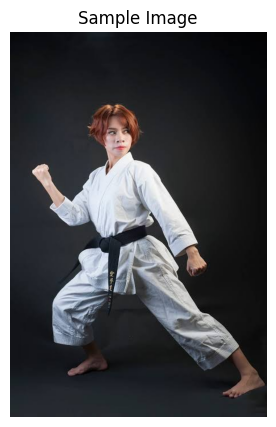

In [3]:
#Read an image from the specific path
sample_img =cv2.imread('images/image1.jpg')

#Specify a size of the figure
plt.figure(figsize = [5,5])

#Display the sample image, also convert BGR to RGB for display
plt.title("Sample Image");plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

### PERFORM POSE DETECTION

In [4]:
#Perform pose detection after converting the image into RGB format
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

#Check if any landmarks are found
if results.pose_landmarks:
    
    #Iterate two times as we only want to display first two landmarks
    for i in range(2):
        
        #Display the found normalized landmarks
        print(f'{mp_pose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}')

NOSE:
x: 0.430625379
y: 0.282983482
z: -0.58512044
visibility: 1

LEFT_EYE_INNER:
x: 0.439393044
y: 0.264790744
z: -0.546215832
visibility: 1



C:\Users\Systems\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


##### convert the two normalized landmark points into their original scale by using width and height of image

In [5]:
#Retrieve the height and width of the sample in image.
image_height, image_width, _=sample_img.shape

#check if any landmarks are found.
if results.pose_landmarks:
    
    #iterate two times as we only want to display first two landmarks.
    for i in range(2):
        
        #Display the found lanmarks after converting them to into their original scale.
        print(f'{mp_pose.PoseLandmark(i).name}:')
        print(f'x:{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].x*image_width}')
        print(f'y:{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].y*image_height}')
        print(f'z:{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].z*image_width}')
        print(f'visibility:{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].visibility}\n')      

NOSE:
x:194.64267134666443
y:192.14578419923782
z:-264.47443866729736
visibility:1.0

LEFT_EYE_INNER:
x:198.60565567016602
y:179.79291489720345
z:-246.8895561695099
visibility:1.0



##### Plot landmarks on the image

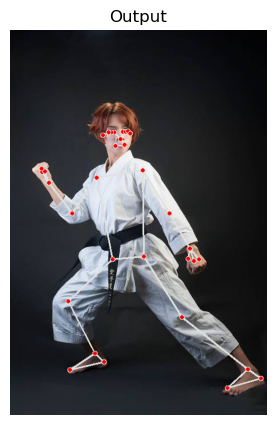

In [59]:
#Create a copy of the sample image to draw lanmarks om
img_copy = sample_img.copy()

#Check if any landmarks are found 
if results.pose_landmarks:

    #Draw pose landmarks on the sample image
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
    
    #Specify a size of the figure
    fig=plt.figure(figsize=[5,5])
    
    #Display the output image with the landmarks drawn, also convert BGR to RGB for display
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()
    

    

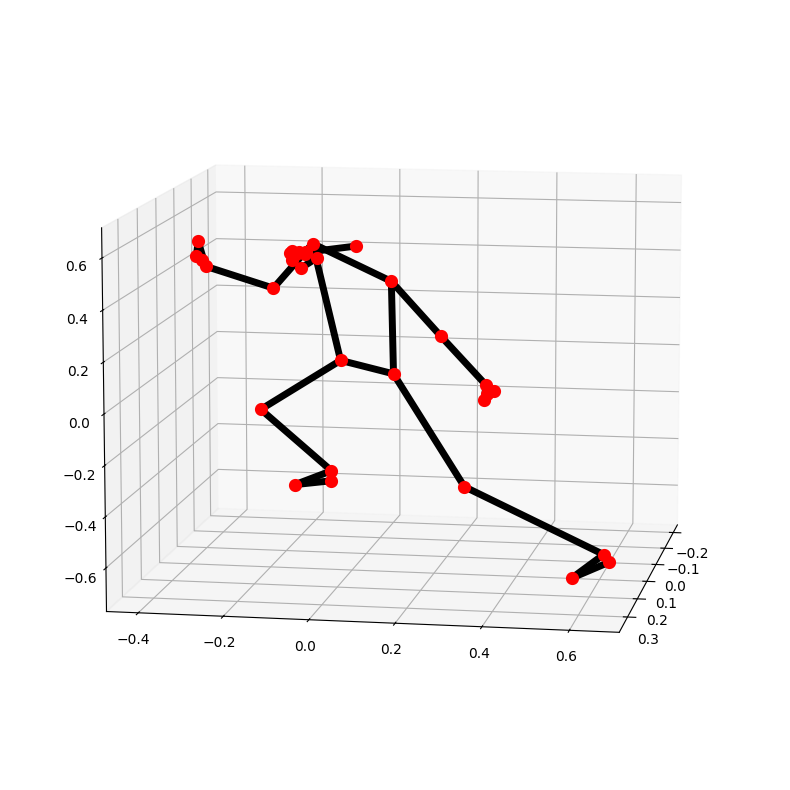

In [6]:
#Plot pose landmarks in 3D
mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

# CREATE POSE DETECT FUNCTION

In [7]:
def detectPose(image, pose, display = True):
    ''' This performs pose detection for image
    image: input image with a person
    pose: the pose setup function req to perform the pose detection
    display: a boolean value that is if set to true the function displays the original input image, the resultant image, and the pose landmarks in 3D plat and returns nothing.

    output_image: The input image with the detected pose landmarks drawn
    landmarks: A list of detected landmarks converted into their original scale.
    '''
    #Create a copy of the input image
    output_image = image.copy()
    
    #Convert the image from BGR into RGB format
    imageRGB=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    #Perform the Pose Detection
    results=pose.process(imageRGB)
    
    #Retrive the height and width of the input image
    height, width, _=image.shape
    
    #Initilize a list to store the detected landmarks
    landmarks =[]
    
    #Check if any landmarks are detected
    if results.pose_landmarks:

        
        #draw pose landmarks on the output image
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
        
        #iterate over the detected landmarks
        for landmark in results.pose_landmarks.landmark:
            
            #Append the landmarks into the list
            landmarks.append((int(landmark.x*width), int(landmark.y*height), (landmark.z*width)))

    #Check if the original input image and the resultant image are specified to be displayed
    if display:    

        #Display the original input image and the resultant image
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        
        #Also Plot the pose landmarks in 3D
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

    #Otherwise
    else:

        #Retuen the output image and the found landmarks
        return output_image, landmarks
        
    
    

##### Example on an image sample

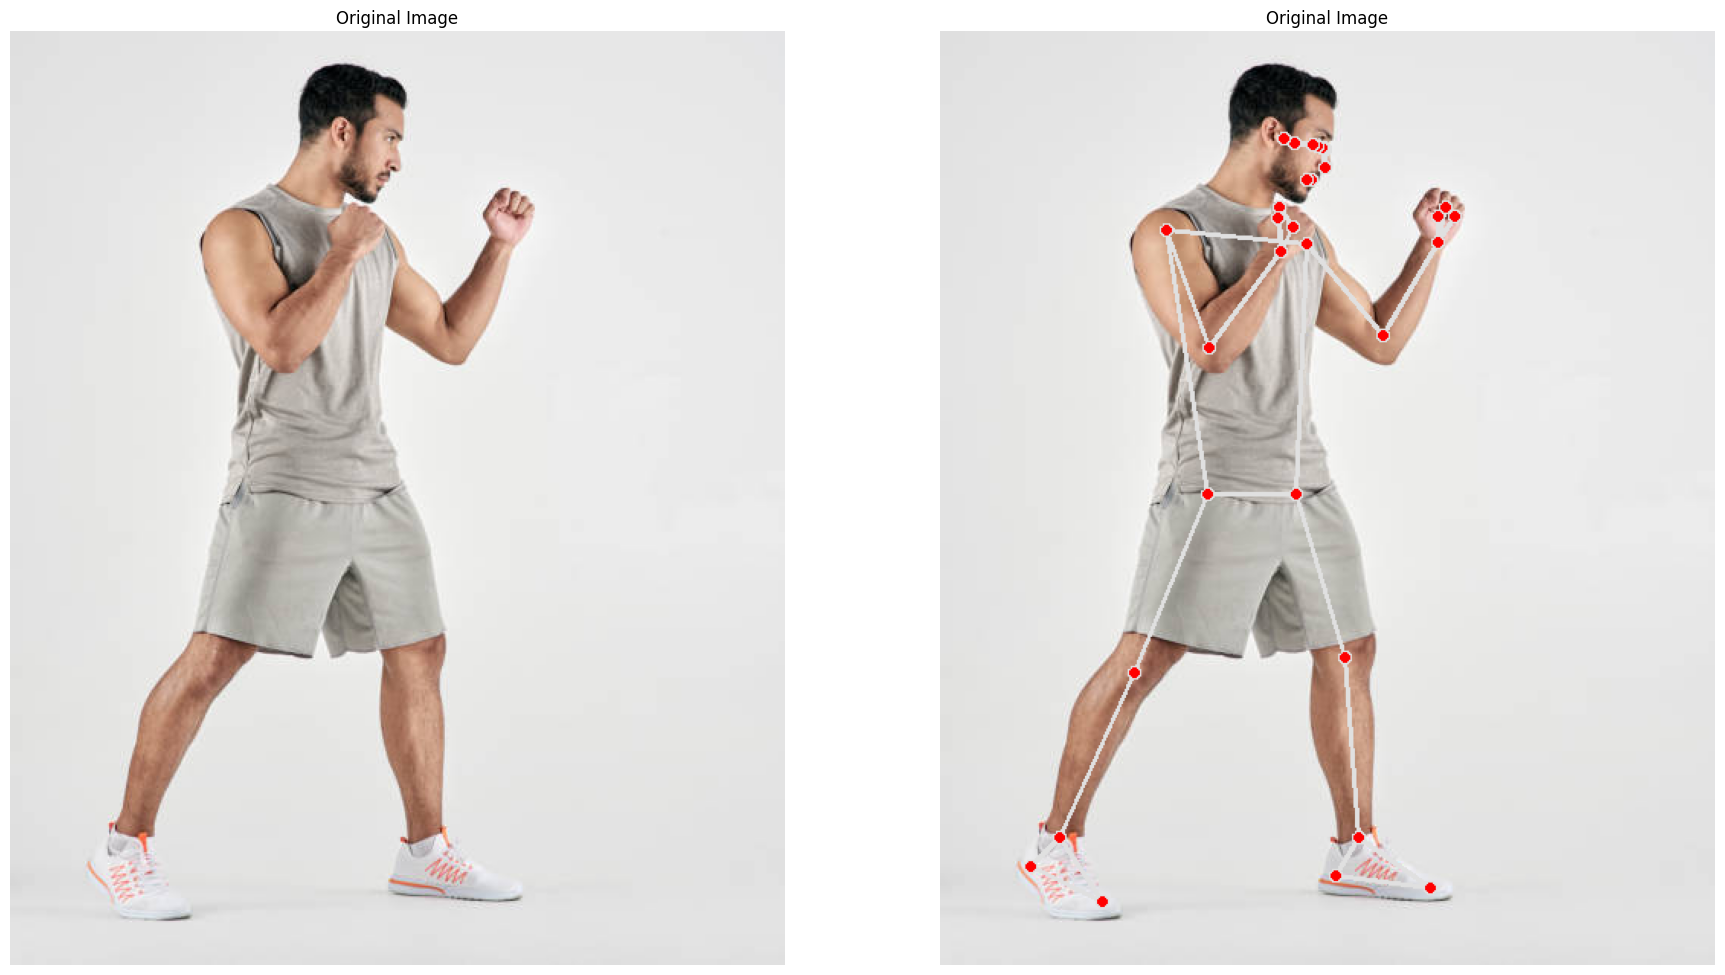

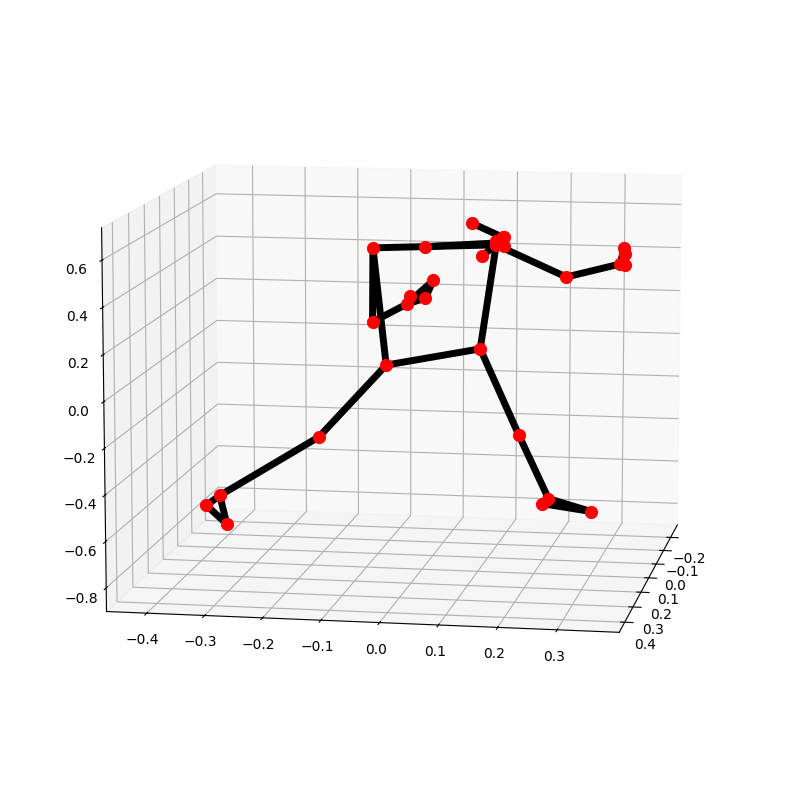

In [8]:
#Read another sample image and perform pose detection on it
image = cv2.imread('images/pose1.jpg')
detectPose(image, pose, display = True)

# POSE CLASSIFICATION FUNCTION
##### using angle heuristics

### CALCULATE ANGLE FUNCTION

In [9]:
def calculateAngle(landmark1, landmark2, landmark3):
    ''' this function calculates angle between three different landmarks
    landmark1: the first landmark containg the x,y and z coordinates.
    landmark2: the second landmark containg the x,y and z coordinates.
    landmark3: the third landmark containg the x,y and z coordinates.
    
    angle: the calculated dangle b/w the three landmarks '''
    
    #get the req landmarks
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3
    #calculate the angle b/w the three points
    angle = math.degrees(math.atan2(y3-y2, x3-x2) - math.atan2(y1-y2,x1-x2))
    #check if the angle is less than zero
    if angle <0:
        #add 360 to the found angle
        angle +=360
    #return the calculated angle
    return angle

In [10]:
#calculate the angle between the three landmarks
angle = calculateAngle((558,326,0),(642,333,0),(718,321,0))
#display the calculated angle
print(f'The calculated angle is {angle}')

The calculated angle is 166.26373169437744


# FUNCTION TO PERFORM POSE CLASSIFICATION

### Following yoga poses: Warrior II Pose, T Pose, Tree Pose

In [11]:
def classifyPose(landmarks, output_image, display=False):
    ''' this function classifies yoga poses depending upon the angles of various body joints
    landmarks: a list of detected landmarks of the person whose pose needs to be classified
    output_image: a image of the person with the detected pose landmark drawn
    display: a boolean value that is if set to true the function displays the resultant image with the pose label written on it and returns nothing
    output_image: the image with detected pose landmarks drawn and pose label written 
    label: the classified pose label of the person in the output_image. '''
    
    #initialize the label of the pose. if it is not known at this stage
    label ='Unkown Pose'
    #specify the color (Red) with which the label will be written on the image
    color=(0,0,255)

    #Calculate the required angles

    #angle b/w left shoulder, elbow and wrist points
    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    #angle b/w right shoulder, elbow and wrist points
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                     landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                     landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])
    #angle b/w left elbow, shoulder and hip points
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])
    #angle b/w right hip, shoulder and elbow points
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                     landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])
    #angle b/w left hip, knee and ankle points
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])
    #angle b/w left hip, knee and ankle points
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    
    
    #Check if it is the warrior II pose or T pose
    #As for both of them, both arms should be straight and shoulders should be at the specific angle

    #Check if both arms are straight
    if left_elbow_angle > 165 and left_elbow_angle <195 and right_elbow_angle > 165 and right_elbow_angle <195:
        #check if shoulders are at the req angle
        if left_shoulder_angle > 80 and left_shoulder_angle <110 and right_shoulder_angle > 80 and right_shoulder_angle <110:
    #Check if Warrior II
            #check if one leg straight
            if left_knee_angle >105 and left_knee_angle < 195 or right_knee_angle >105 and right_knee_angle < 195:
                #Check if the other leg is bended at the required angle
                if left_knee_angle >90 and left_knee_angle < 120 or right_knee_angle >90 and right_knee_angle < 120:
                    #specify label of the pose as Warrior II
                    label = 'Warrior II Pose'

    #Check if T Pose
            #Check if both legs are straight
            if left_knee_angle >160 and left_knee_angle < 195 and right_knee_angle >160 and right_knee_angle < 195:
                #specify label of the pose as Warrior II
                    label = 'T Pose'

    # Check if Tree Pose
    # Check if one leg is straight
    if left_knee_angle >165 and left_knee_angle < 195 or right_knee_angle >165 and right_knee_angle < 195:
        #Check if the other leg is bended at req angle
        if left_knee_angle >315 and left_knee_angle < 335 or right_knee_angle >25 and right_knee_angle < 45:
            #specify label of the pose as Warrior II
                    label = 'Tree Pose'

    #Check if pose is classified successfully
    if label != 'Unknown Pose':
        #Update the color(to green) with the label will be written on the image
        color = (0,255,0)

    #Write the label on the output image
    cv2.putText(output_image, label, (10,30), cv2.FONT_HERSHEY_PLAIN, 2, color, 2)

    #Check if the resultant image is specifies to be displayed
    if display:
        #Display the resultant image
        plt.figure(figsize=[7,7])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');

    else:
        #Return the output image and the classified label
        return output_image, label
        

    



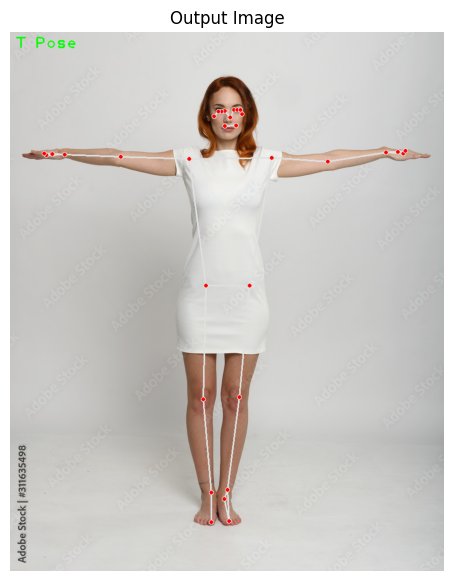

In [12]:
#Read a sample image and perform pose classification on it.
image = cv2.imread('images/t pose.jpg')
output_image, landmarks=detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

# POSE DETECTION AND CLASSIFICATION ON REAL TIME WEBCAM FEED

In [13]:
#Setup Pose function for video
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

#Intialize the VideoCapture object to read from the webcam
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

#Initialize a resizable window
cv2.namedWindow('Pose Classification', cv2. WINDOW_NORMAL)

#Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    #Read a frame
    ok, frame = camera_video.read()
    #check if frame is not read properly
    if not ok:
        #continue to the next iteration to read the next frame and ignore the empty camera frame
        continue
    #Flip the frame horizontally for natural (selfie-view) viisualization
    frame = cv2.flip(frame, 1)
    #Get the width and height of the frame
    frame_height, frame_width, _ = frame.shape
    #Resize the frame while keeping the aspect ratio
    frame= cv2.resize(frame, (int(frame_width * (640/ frame_height)), 640))
    #Perform Pose Landmark detection
    frame, landmarks = detectPose(frame, pose_video, display=False)

    #Check if landmarks are detected
    if landmarks:
        #Perform the Pose  Classification
        frame, _ = classifyPose(landmarks, frame, display=False)

    #Display the frame
    cv2.imshow('Pose Classification', frame)


    #Wait until a key is pressed
    #Retreive the ASCII code of the key presses
    k = cv2.waitKey(1) & 0xFF

    #Check if 'ESC' is pressed
    if (k== 27):
        #break the line
        break

#Release the VideoCapture object and close the window
camera_video.release()
cv2.destroyAllWindows()
        